In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
folder = "/content/gdrive/My Drive/"

!pip install biopython
!pip install cooler
!pip install cooltools

from IPython.display import clear_output
clear_output()
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import gc

sys.path.append(folder)
from .dataset import DataMaster
from .training import ModelMaster

In [ ]:
!wget https://makarich.fbb.msu.ru/agalicina/Lab_open/HIC_DB/MM9/bonemarrow_B_nan_B.10000.cool
!wget https://hgdownload.cse.ucsc.edu/goldenPath/mm9/bigZips/mm9.fa.gz
!gunzip ./mm9.fa.gz

genome = 'mm9.fa'
hic_name = 'bonemarrow_B_nan_B.10000.cool'

In [ ]:
!wget https://storage.googleapis.com/basenji_hic/tutorials/coolers/HFF_hg38_4DNFIP5EUOFX.mapq_30.2048.cool
!wget https://storage.googleapis.com/basenji_barnyard/hg38.ml.fa.gz
!gunzip ./hg38.ml.fa.gz
clear_output()

genome = 'hg38.ml.fa'
hic_name = 'HFF_hg38_4DNFIP5EUOFX.mapq_30.2048.cool'

In [ ]:
data = DataMaster(
                 hic_file = hic_name, 
                 genome_file_or_dir = genome, 
                 fragment_length = 2**18,
                 sigma = 2,
                 chroms_to_exclude = ['chrX', 'chr14','chr15','chr16','chr17','chr18','chr19'],
                 scale = None,
                 map_size = 64,
                 nan_threshold = 0.2,
                 rev_comp = False,
                 stochastic_sampling = False,
                 shift_repeats = 1,
                 expand_dna = False,
                 dna_encoding = 'one-hot',
                 val_split = ('first', 64),
                 cut_chromosome_ends = 2**22,
                 sample_seed = 0)

In [ ]:
import importlib
import hicpredictor.training as training
importlib.reload(training)
ModelMaster = training.ModelMaster

In [ ]:
genome = 'hg38.ml.fa'
hic_name = 'HFF_hg38_4DNFIP5EUOFX.mapq_30.2048.cool'
data = DataMaster(
                 hic_file = hic_name, 
                 genome_file_or_dir = genome, 
                 fragment_length = 2**18,
                 sigma = 2,
                 chroms_to_exclude = ['chrX', 'chr14','chr15','chr16','chr17'],
                 scale = None,
                 map_size = 64,
                 nan_threshold = 0.2,
                 rev_comp = True,
                 stochastic_sampling = False,
                 shift_repeats = 2,
                 expand_dna = False,
                 dna_encoding = 'one-hot',
                 val_split = ('first', 64),
                 cut_chromosome_ends = 2**22,
                 sample_seed = 0)

DNA data for chr1 is loaded
DNA data for chr10 is loaded
DNA data for chr11 is loaded
DNA data for chr12 is loaded
DNA data for chr13 is loaded
DNA data for chr18 is loaded
DNA data for chr19 is loaded
DNA data for chr2 is loaded
DNA data for chr20 is loaded
DNA data for chr21 is loaded
DNA data for chr22 is loaded
DNA data for chr3 is loaded
DNA data for chr4 is loaded
DNA data for chr5 is loaded
DNA data for chr6 is loaded
DNA data for chr7 is loaded
DNA data for chr8 is loaded
DNA data for chr9 is loaded

Maps are zoomed 0.5 times
For 64x64 map used 262144 nucleotide fragments
Initial dataset contains 524288x524288 maps, overlooping in 64 pixels
128x128 maps for training will be sampled from them, maps for testing are their top left fragments
Hi-C data for chr1 is loaded
Hi-C data for chr10 is loaded
Hi-C data for chr11 is loaded
Hi-C data for chr12 is loaded
Hi-C data for chr13 is loaded
Hi-C data for chr18 is loaded
Hi-C data for chr19 is loaded
Hi-C data for chr2 is loaded
Hi-C d

In [ ]:
Model = ModelMaster(data,
        saving_dir = folder+'Human_2', 
        model_dir = folder+'Human_1', 
        rewrite = True,  
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])

Hi-C maps successfully encoded


In [ ]:
latent_dim = 24
input_len = 2**18

def enc():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(input_shape=(64, 64, 1), filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim, activation='linear')])
    return model

def dec():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(input_shape=(latent_dim, ), units=16*16*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='linear')])
    return model

def model(input_len=data.dna_len):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_len, 4)))

    model.add(tf.keras.layers.Conv1D(64, 11, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    pooling_range = int(np.log2(input_len)) - 8
    for block in range(pooling_range):
        model.add(tf.keras.layers.Conv1D(64, 5, padding='same', dilation_rate = 2, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.15))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(latent_dim))

    model.compile(loss = 'mse', optimizer = 'nadam')

    return model

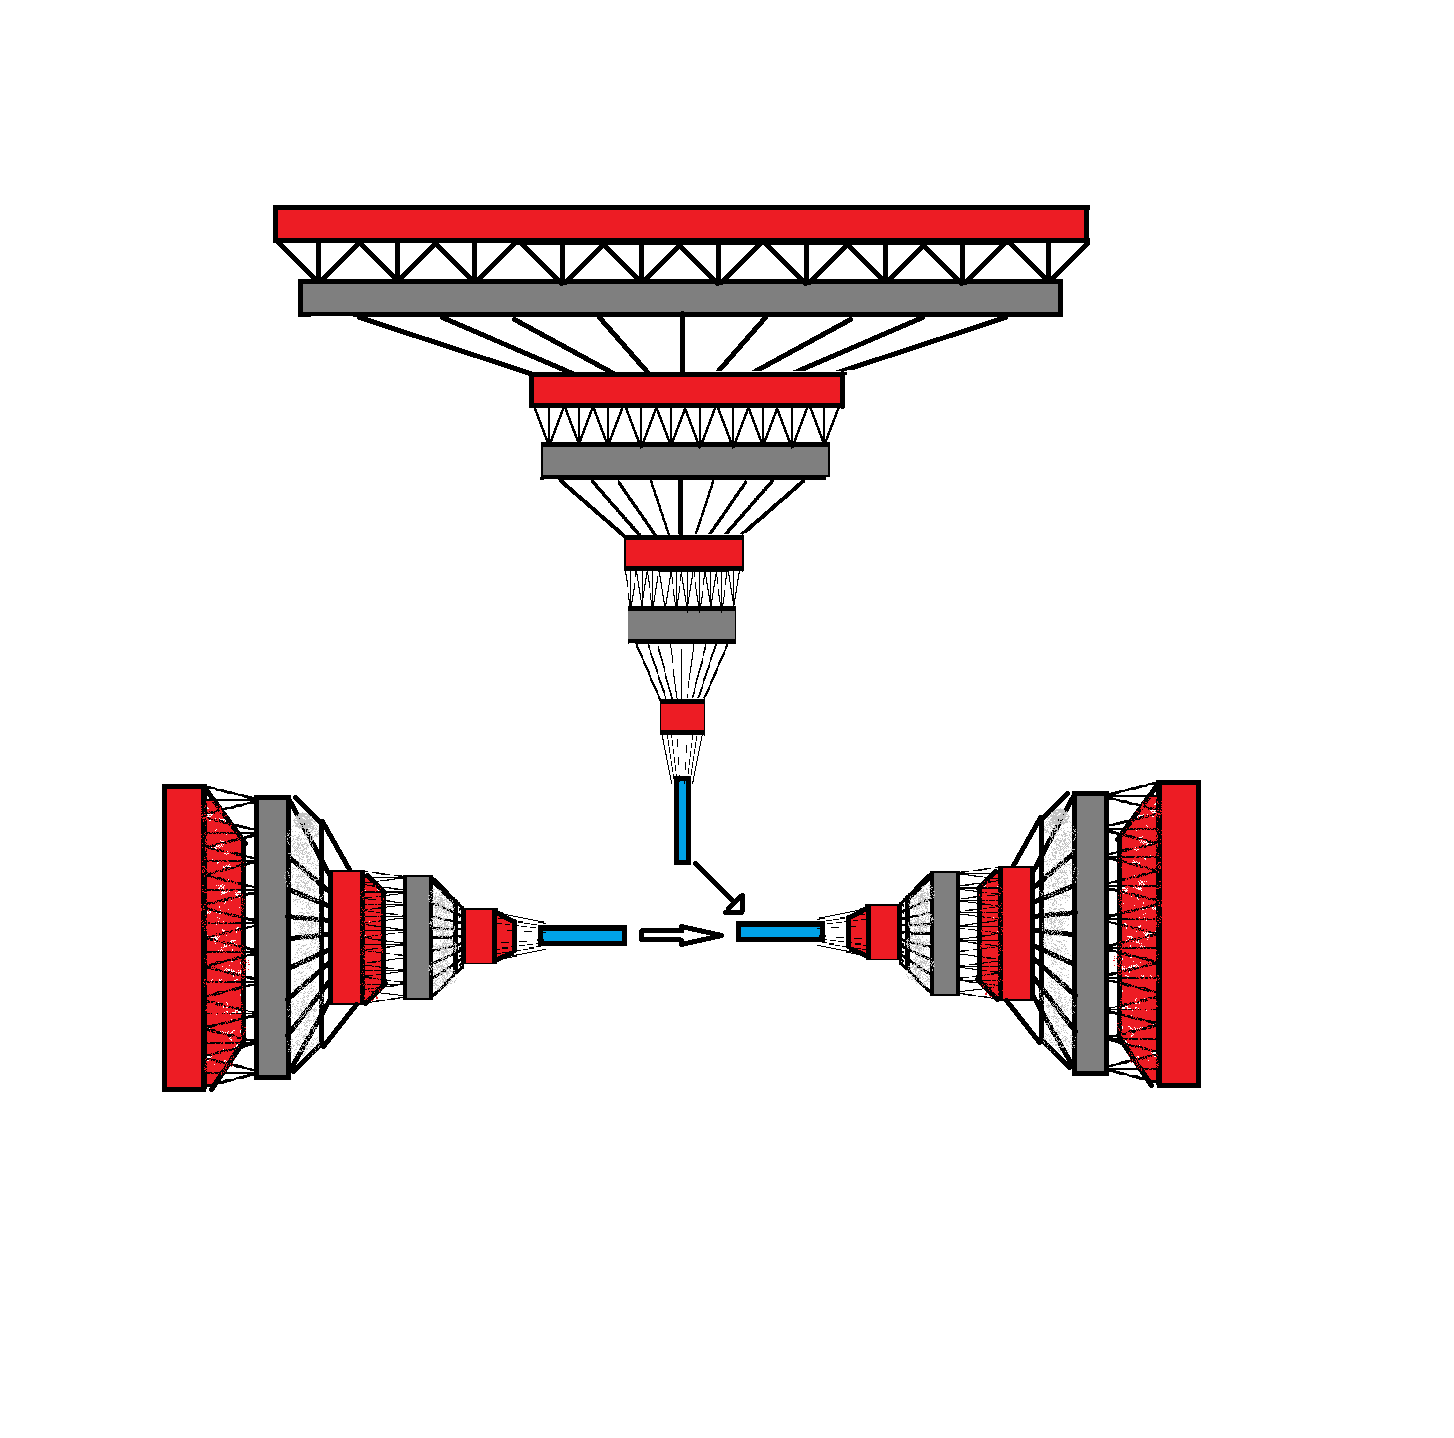

In [ ]:
latent_dim = 24
input_len = 2**18
def model(input_len=data.dna_len):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_len, 4)))

    model.add(tf.keras.layers.Conv1D(64, 11, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    pooling_range = int(np.log2(input_len)) - 8
    for block in range(pooling_range):
        model.add(tf.keras.layers.Conv1D(64, 5, padding='same', dilation_rate = 2, activation='relu'))
        #model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.15))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(latent_dim))

    model.compile(loss = 'mse', optimizer = 'nadam')

    return model
Model.build_model(model)

In [ ]:
Model.train(1000, 8, callbacks='classical')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 262144, 64)        2880      
_________________________________________________________________
batch_normalization (BatchNo (None, 262144, 64)        256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 131072, 64)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 131072, 64)        20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 131072, 64)        256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 65536, 64)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65536, 64)         2

KeyboardInterrupt: ignored

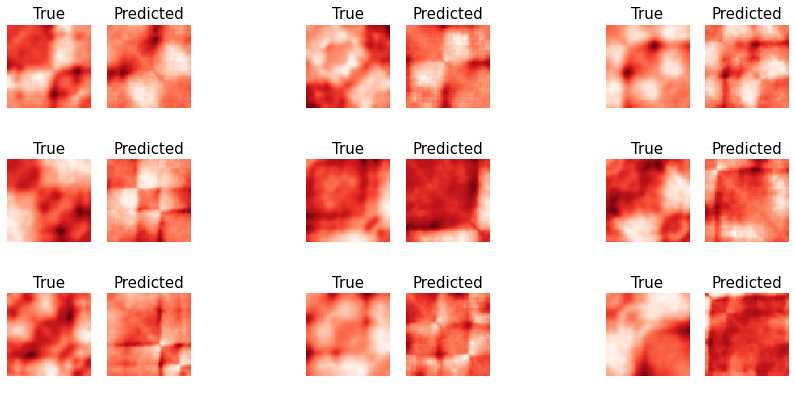

In [ ]:
Model.predict_as_training = False
Model.plot_results(['val', 10])

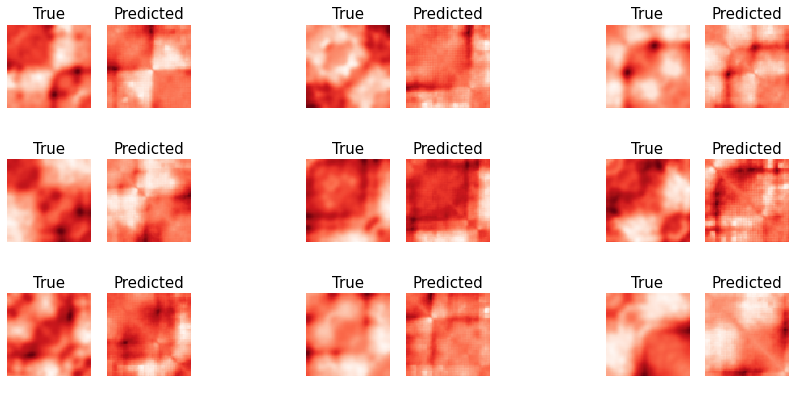

In [ ]:
Model.predict_as_training = True
Model.plot_results(['val', 10])

In [ ]:
Model = ModelMaster(data,
        saving_dir = folder+'Human_2', 
        model_dir = folder+'Human_2', 
        rewrite = True,  
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])

Hi-C maps successfully encoded


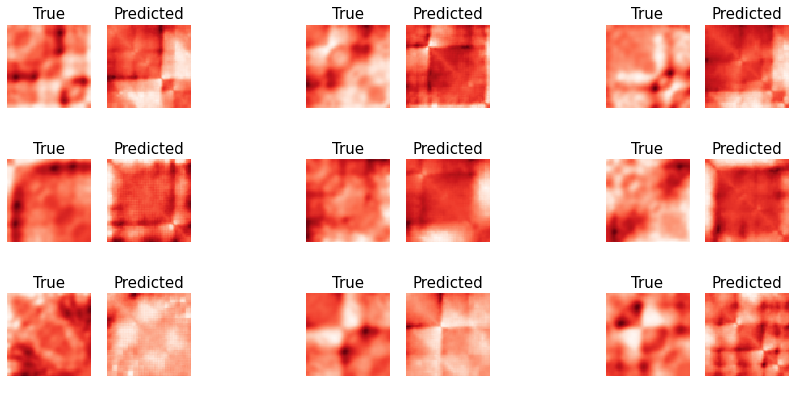

In [ ]:
Model.predict_as_training = False
Model.plot_results(['val', 20])

Hi-C maps successfully encoded
DNA data for chr14 is loaded

Maps are zoomed 0.5 times
For 64x64 map used 262144 nucleotide fragments
Initial dataset contains 524288x524288 maps, overlooping in 64 pixels
128x128 maps for training will be sampled from them, maps for testing are their top left fragments
Hi-C data for chr14 is loaded
79/79 [==============================] - 30s 375ms/step


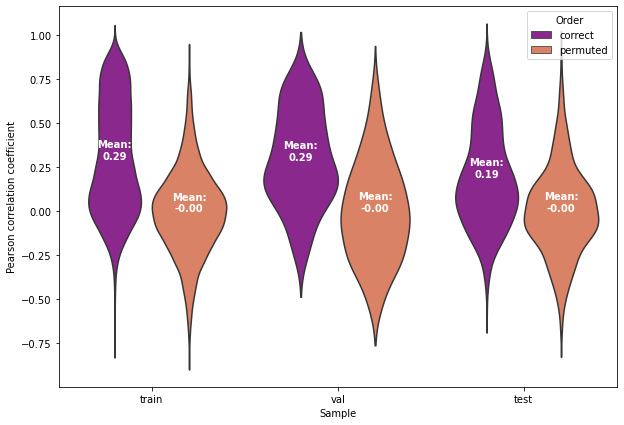

In [ ]:
Model = ModelMaster(data,
        saving_dir = folder+'Human_1', 
        model_dir = folder+'Human_1', 
        rewrite = True,  
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])
Model.predict_as_training = False
Model.load_test_chromosome('chr14')
Model.score()

DNA data for chr14 is loaded

Maps are zoomed 0.5 times
For 64x64 map used 262144 nucleotide fragments
Initial dataset contains 524288x524288 maps, overlooping in 64 pixels
128x128 maps for training will be sampled from them, maps for testing are their top left fragments
Hi-C data for chr14 is loaded
79/79 [==============================] - 30s 369ms/step


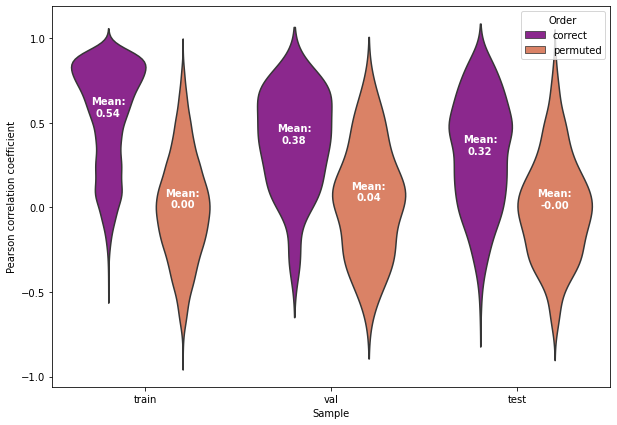

In [ ]:
Model.load_test_chromosome('chr14')
Model.score()

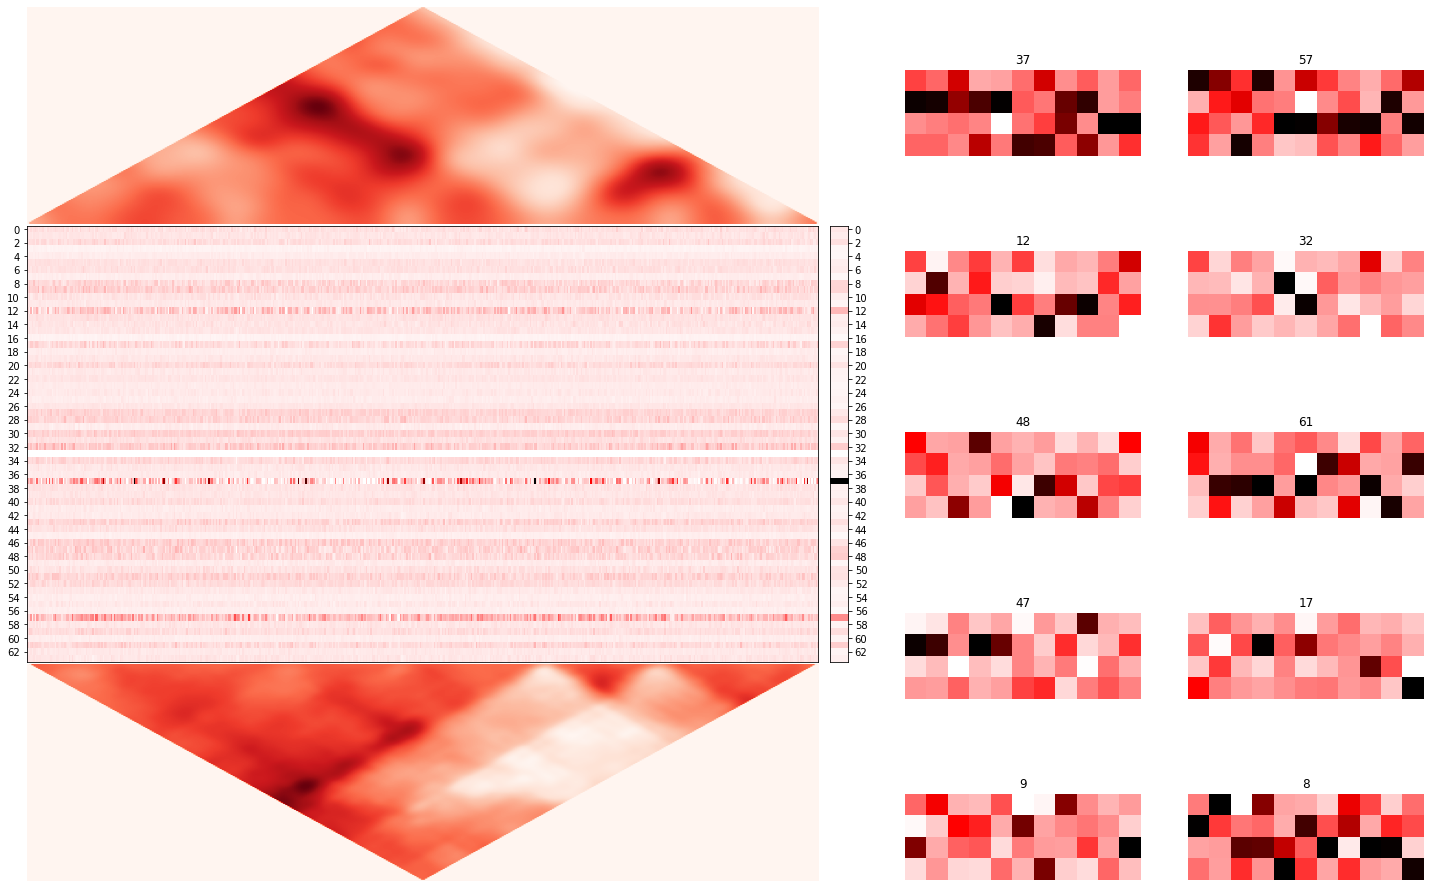

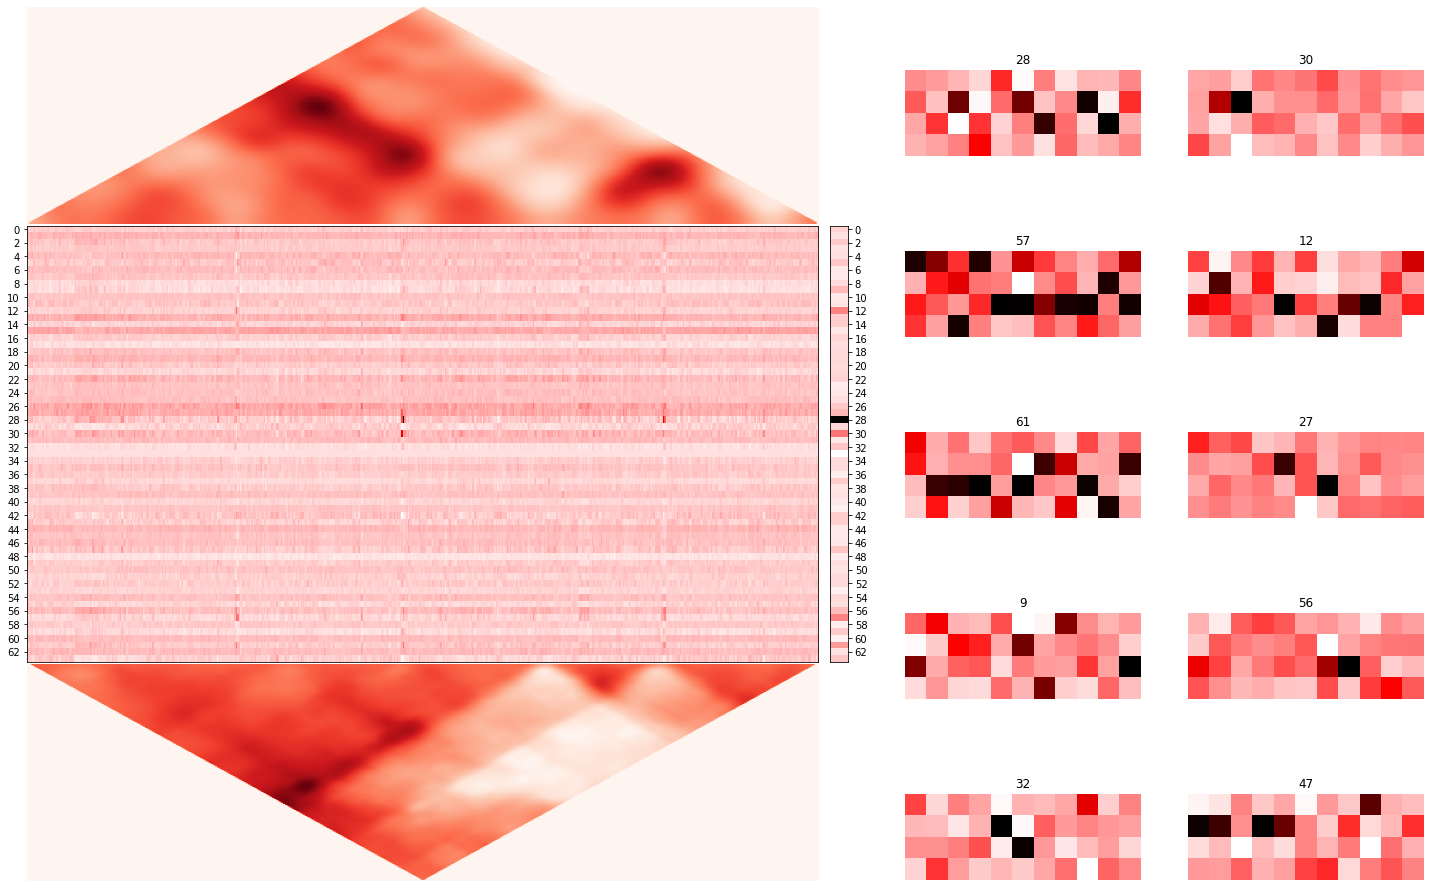

In [ ]:
filters = Model.graphic_analisis(20,
                                theme='light',
                                n_layers=3,
                                color_shifts={'heatmap': 210, 'filters': 200},
                                return_filters=True,
                                aggregation='max')
filters = Model.graphic_analisis(20,
                                theme='light',
                                n_layers=3,
                                color_shifts={'heatmap': 210, 'filters': 200},
                                return_filters=True,
                                aggregation='mean')

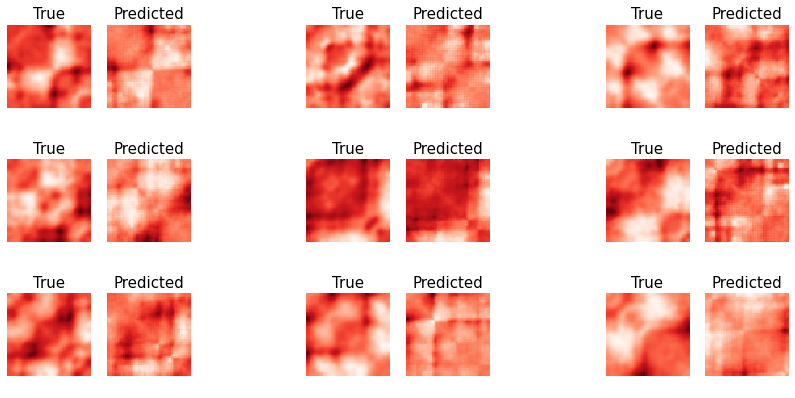

In [ ]:
Model.plot_results(['val', 10])

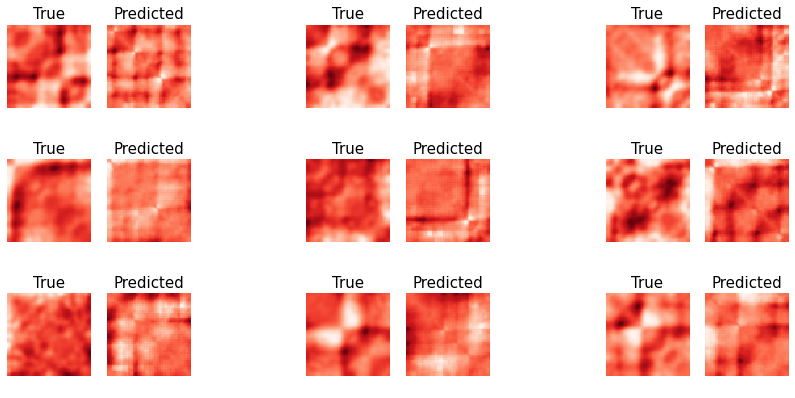

In [ ]:
Model.plot_results(['val', 20])

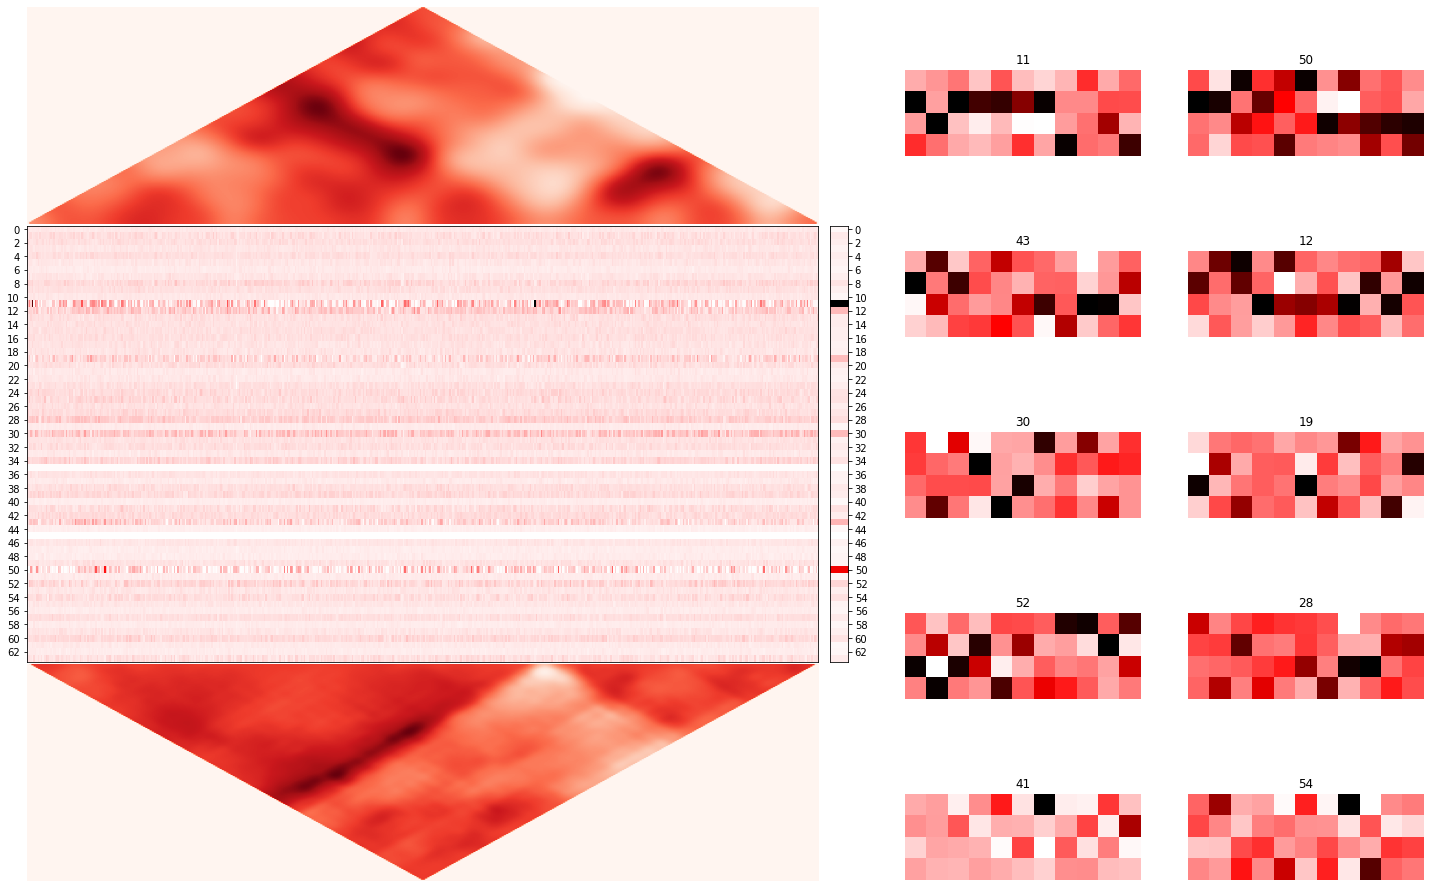

In [ ]:
filters = Model.graphic_analisis(20,
                                theme='light',
                                n_layers=3,
                                color_shifts={'heatmap': 210, 'filters': 200},
                                return_filters=True,
                                aggregation='max')

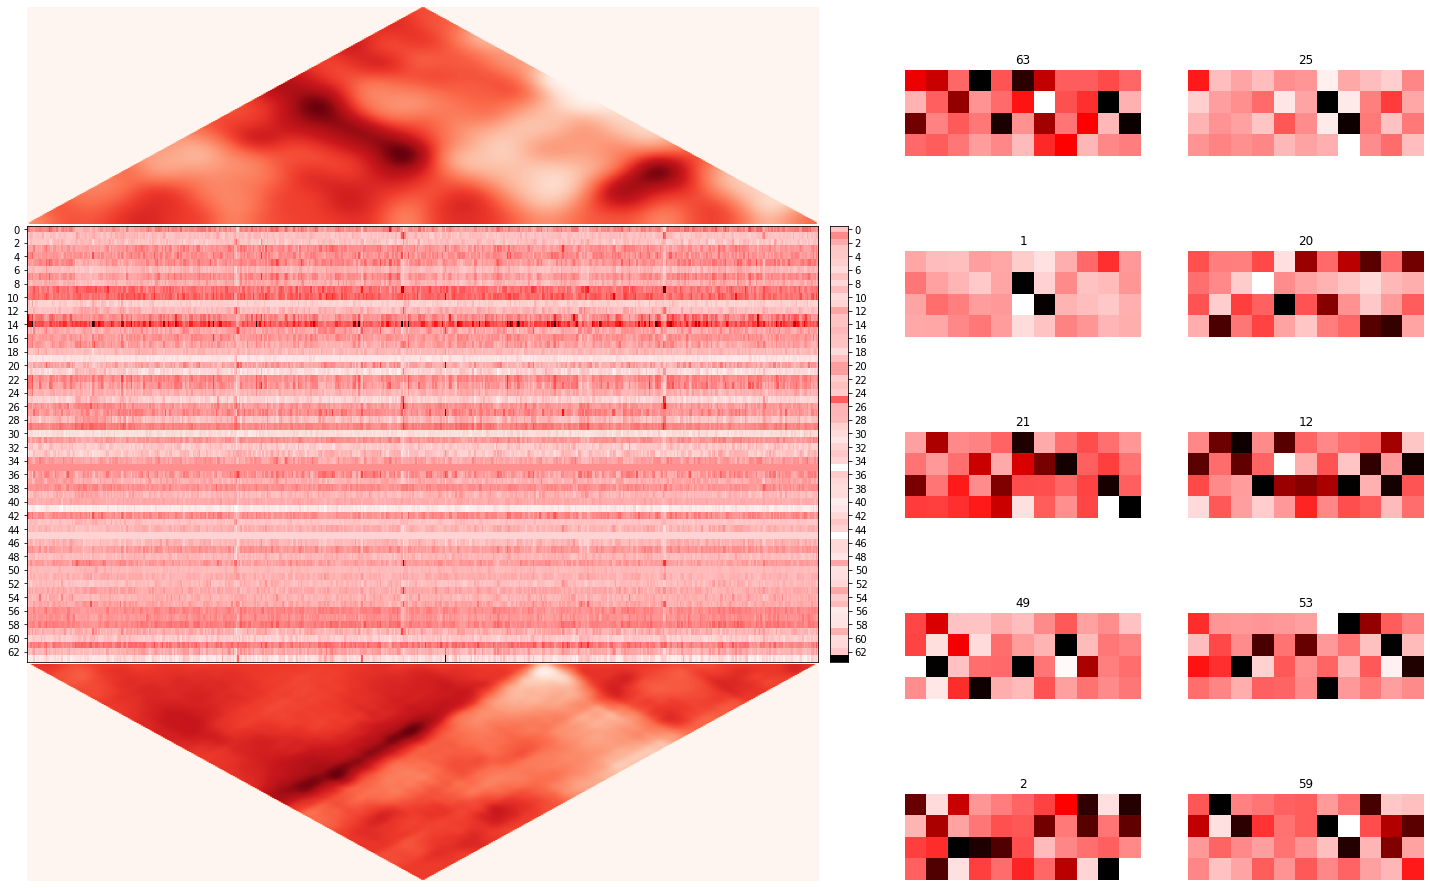

In [ ]:
filters = Model.graphic_analisis(20,
                                theme='light',
                                n_layers=3,
                                color_shifts={'heatmap': 210, 'filters': 200},
                                return_filters=True,
                                aggregation='mean')

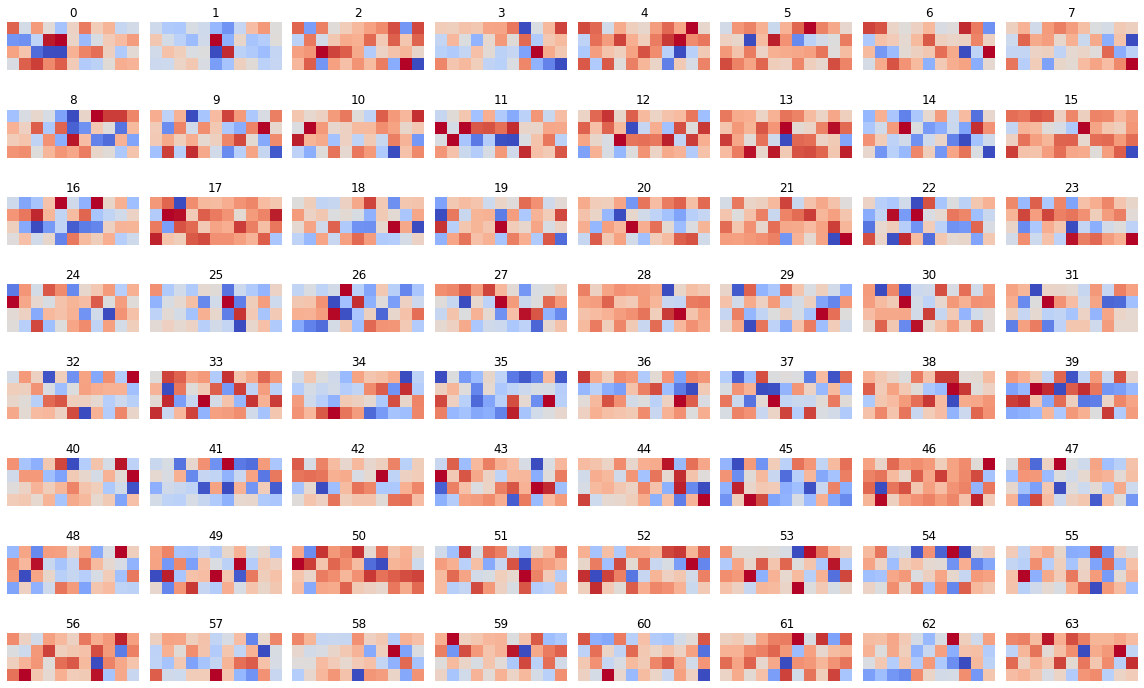

In [ ]:
Model.plot_filters()

In [ ]:
Model.load_test_chromosome('chr14')

In [ ]:
Model.score()

Pearson correlation for training sample (random 128): 0.4935
Pearson correlation for validation sample (whole - 64): 0.4076
Pearson correlations for both samples where X and y are permuted:   -0.0280, -0.0198

Test data contains chromosomes: chr14
Pearson correlation for test sample (used 128 elements): 0.3638
Pearson correlation for test sample where X and y are permuted: -0.0119


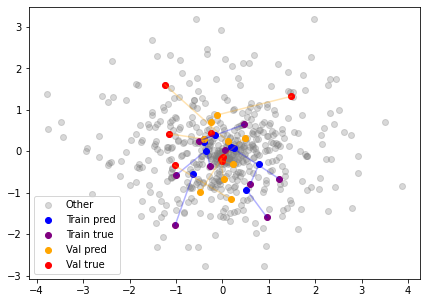

In [ ]:
Model.plot_pca()

In [ ]:
data = DataMaster(
                 hic_file = hic_name, 
                 genome_file_or_dir = genome, 
                 fragment_length = 2**18,
                 sigma = 2,
                 chroms_to_exclude = ['chrX', 'chr14','chr15','chr16','chr17','chr18','chr19'],
                 scale = (0,1),
                 map_size = 64,
                 nan_threshold = 0.2,
                 rev_comp = False,
                 stochastic_sampling = False,
                 shift_repeats = 2,
                 expand_dna = False,
                 dna_encoding = 'one-hot',
                 val_split = ('first', 64),
                 cut_chromosome_ends = 2**22,
                 sample_seed = 0)

DNA data for chr1 is loaded
DNA data for chr10 is loaded
DNA data for chr11 is loaded
DNA data for chr12 is loaded
DNA data for chr13 is loaded
DNA data for chr2 is loaded
DNA data for chr20 is loaded
DNA data for chr21 is loaded
DNA data for chr22 is loaded
DNA data for chr3 is loaded
DNA data for chr4 is loaded
DNA data for chr5 is loaded
DNA data for chr6 is loaded
DNA data for chr7 is loaded
DNA data for chr8 is loaded
DNA data for chr9 is loaded

Maps are zoomed 0.5 times
For 64x64 map used 262144 nucleotide fragments
Initial dataset contains 524288x524288 maps, overlooping in 64 pixels
128x128 maps for training will be sampled from them, maps for testing are their top left fragments
Hi-C data for chr1 is loaded
Hi-C data for chr10 is loaded
Hi-C data for chr11 is loaded
Hi-C data for chr12 is loaded
Hi-C data for chr13 is loaded
Hi-C data for chr2 is loaded
Hi-C data for chr20 is loaded
Hi-C data for chr21 is loaded
Hi-C data for chr22 is loaded
Hi-C data for chr3 is loaded
Hi-C 

In [ ]:
latent_dim = 24
input_len = 2**18

def enc():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(input_shape=(64, 64, 1), filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim, activation='linear')])
    return model

def dec():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(input_shape=(latent_dim, ), units=16*16*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')])
    return model

def model(input_len=data.dna_len):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_len, 4)))

    model.add(tf.keras.layers.Conv1D(64, 11, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    pooling_range = int(np.log2(input_len)) - 8
    for block in range(pooling_range):
        model.add(tf.keras.layers.Conv1D(64, 5, padding='same', dilation_rate = 2, activation='relu'))
        #model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    model.add(tf.keras.layers.Flatten())
    #model.add(tf.keras.layers.Dropout(0.15))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(latent_dim))

    model.compile(loss = 'mse', optimizer = 'nadam')

    return model

In [ ]:
Model = ModelMaster(data,
        saving_dir = folder+'Human_3',  
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])
Model.build_enc(enc)
Model.build_dec(dec)
Model.build_model(model)

In [ ]:
Model.train(1000, batch_size=8, callbacks='classical')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 262144, 64)        2880      
_________________________________________________________________
batch_normalization (BatchNo (None, 262144, 64)        256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 131072, 64)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 131072, 64)        20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 131072, 64)        256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 65536, 64)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65536, 64)        

KeyboardInterrupt: ignored

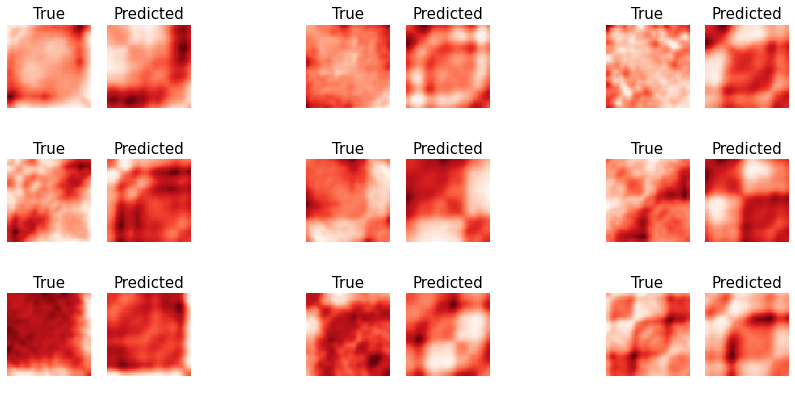

In [ ]:
Model.plot_results()

In [ ]:
Model.predict_as_training = False

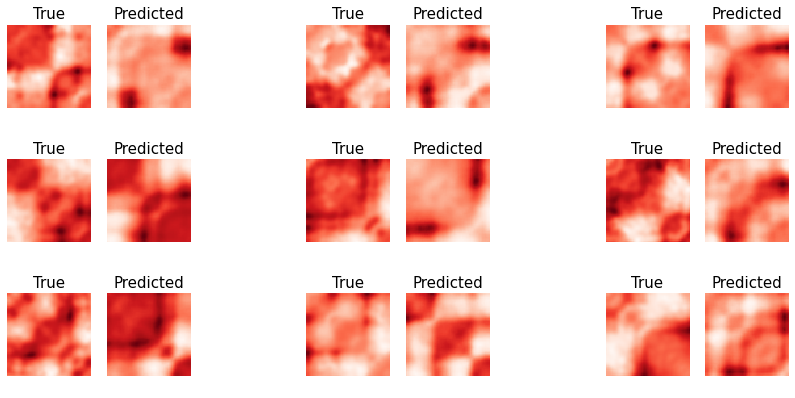

In [ ]:
Model.plot_results(['val', 20])

16/16 [==============================] - 6s 401ms/step


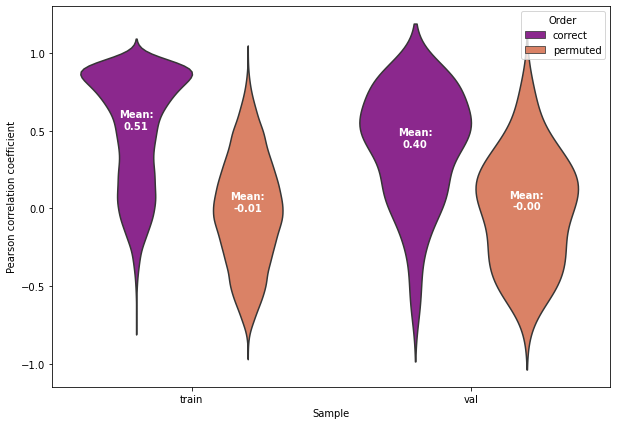

In [ ]:
Model.score()

In [ ]:
Model = ModelMaster(data,
        saving_dir = folder+'Human_4',
        model_dir = folder+'Human_3',
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])
latent_dim=24
def model(input_len=data.dna_len):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_len, 4)))

    model.add(tf.keras.layers.Conv1D(64, 11, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    pooling_range = int(np.log2(input_len)) - 8
    for block in range(pooling_range):
        #model.add(tf.keras.layers.Conv1D(64, 5, padding='same', dilation_rate = 2, activation='relu'))
        model.add(tf.keras.layers.Dense(64))
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.15))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(latent_dim))

    model.compile(loss = 'mse', optimizer = 'nadam')

    return model
Model.build_model(model)

In [ ]:
Model.train(1000, batch_size=8, callbacks='classical')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 262144, 64)        2880      
_________________________________________________________________
batch_normalization_12 (Batc (None, 262144, 64)        256       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 131072, 64)        0         
_________________________________________________________________
dense_10 (Dense)             (None, 131072, 64)        4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 131072, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 131072, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 131072, 64)       

KeyboardInterrupt: ignored

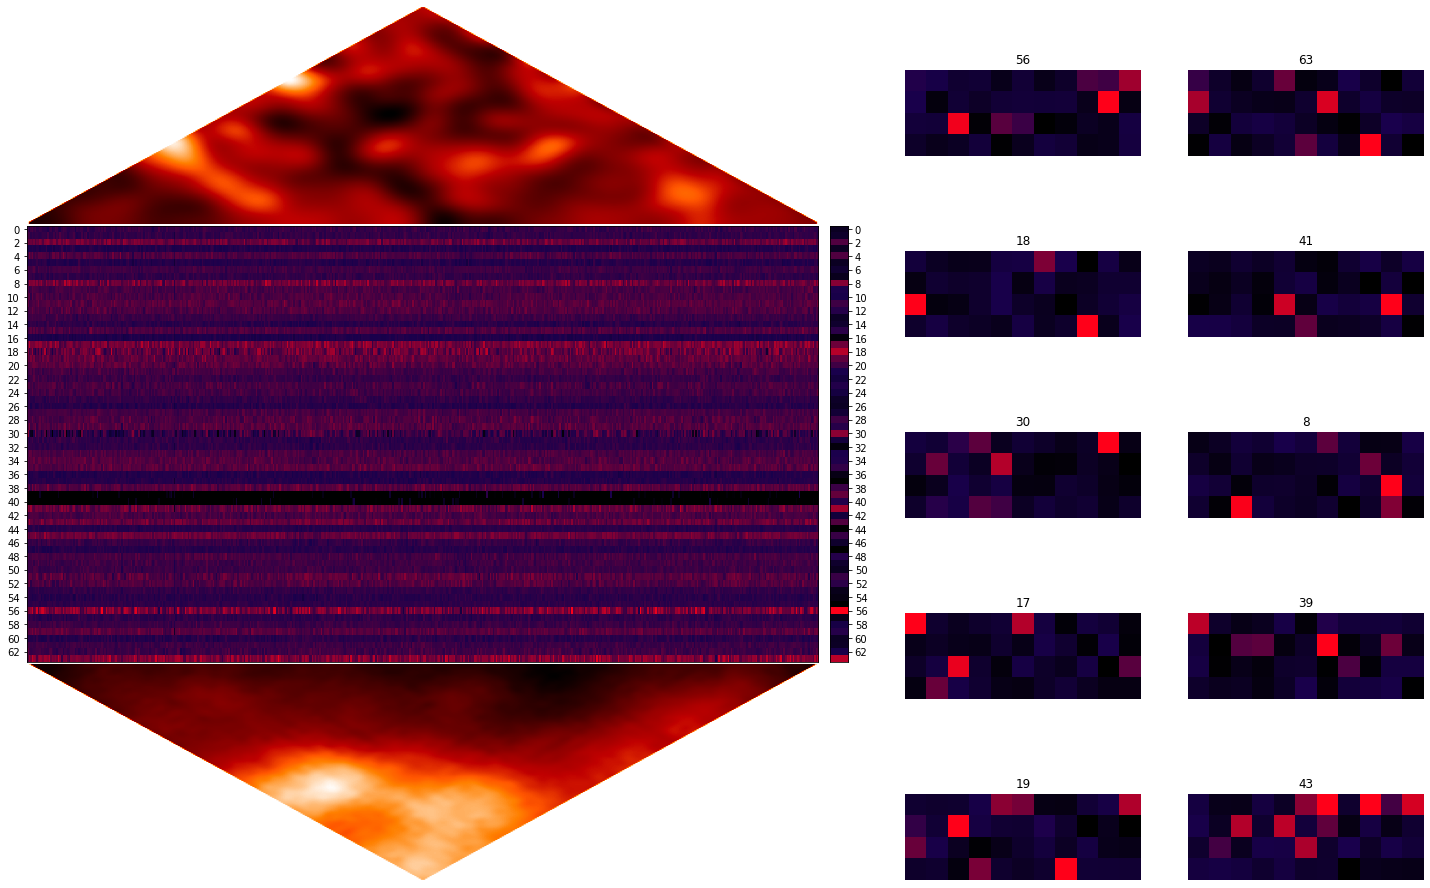

In [ ]:
Model.graphic_analisis(1)